## Measure the Uptime Per Node
We want to make sure that the uptime workers are maintained

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import json

Config

In [2]:
name_to_method = {
    'Train': ('training', "train_generator"),
    'Generate': ('generation', "run_generator"),
    'LAMMPS': ('simulation', "run_molecular_dynamics"),
    'CP2K': ('simulation', "run_optimization")
}

## Get the Uptimes for Different Tasks
Show that everything is working as desired

In [3]:
path = Path('../prod-runs/450-nodes/')

In [4]:
def get_workers_by_type(path: Path) -> dict[str, int]:
    """Get the number of workers for each type of task"""

    node_names = []
    compute = json.loads((path / 'compute-config.json').read_text())

    return {
        'Train': 1,
        'Generate': (len(compute['ai_hosts']) - 1) * compute['gpus_per_node'],
        'LAMMPS': len(compute['lammps_hosts']) * compute['gpus_per_node'] * compute['lammps_per_gpu'],
        'CP2K': len(compute['cp2k_hosts']) // compute['nodes_per_cp2k']
    }
    return compute
worker_counts = get_workers_by_type(path)
worker_counts

{'Train': 1, 'Generate': 176, 'LAMMPS': 2440, 'CP2K': 50}

Count the number of active tasks for each task type

In [5]:
def count_active_workers(path, worker_counts: dict[str, int]) -> dict[str, pd.DataFrame]:
    """Count the number of active workers for each type of worker"""

    # Get the first 
    start_time = np.inf
    for file in path.glob('*-results.json'):
        with open(file) as fp:
            for line in fp:
                record = json.loads(line)
                start_time = min(record['timestamp']['created'], start_time)

    # Get the utilization for each task type
    output = {}
    for task_type, total_count in worker_counts.items():
        file_prefix, method_name = name_to_method[task_type]
        
        # Load the spans for each task
        tasks = []
        with open(path / f'{file_prefix}-results.json') as fp:
            # Gather the spans of all tasks
            for line in fp:
                record = json.loads(line)
                if record['method'] == method_name:
                    tasks.append({
                        'start_time': record['timestamp']['compute_started'] - start_time,
                        'end_time': record['timestamp']['compute_ended'] - start_time
                    })
            tasks = pd.DataFrame(tasks)

            # Compute the number active
            events = [{'time': 0, 'active_delta': 0}]
            events.extend({'time': t, 'active_delta': -1} for t in tasks['end_time'])
            events.extend({'time': t, 'active_delta': 1} for t in tasks['start_time'])
            events = pd.DataFrame(events).sort_values('time')

            # Compute the utilization
            events['num_active'] = events['active_delta'].cumsum()
            events['utilization'] = events['num_active'] / total_count

            output[task_type] = events
    return output
util_data = count_active_workers(path, worker_counts)

Plot the utilization by task type

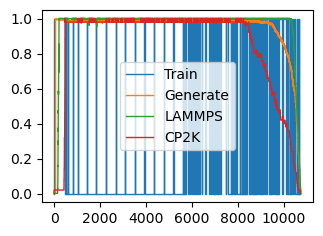

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for task_type, events in util_data.items():
    ax.step(events['time'], events['utilization'], label=task_type, lw=1)

ax.legend()

In [7]:
def cumulative_utilization(events, time: float) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate over all of the pieces before the current piece
    past_events = events[events.time <= time]
    if len(past_events) <= 1:
        return 0.0
    past_util = (np.diff(past_events['time'].values) * past_events['utilization'].values[:-1]).sum()
    
    # Integrate the current piece
    current_event = past_events.iloc[-1]
    current_util = (time - current_event.time) * current_event.utilization
    return (past_util + current_util) / time

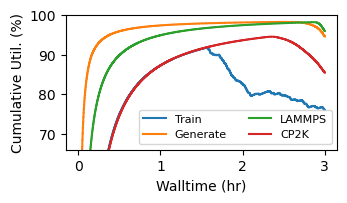

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

times = np.linspace(0, 3 * 3600, 1024)
for task_type, events in util_data.items():
    util = [cumulative_utilization(events, t) * 100 for t in times]
    ax.step(times / 3600, util, label=task_type)

ax.set_ylim(66, 100)

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('Cumulative Util. (%)')
ax.legend(ncol=2, fontsize=8)

In [9]:
def window_utilization(events, time: float, window_size) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate the pieces that fall within the window
    in_events = events[events.time <= time]
    in_events = in_events[in_events.time >= time - window_size]
    if len(in_events) <= 1:
        in_util = 0
    else:
        in_util = (np.diff(in_events['time'].values) * in_events['utilization'].values[:-1]).sum()
    
        # Integrate the current piece (last in event to now)
        current_event = in_events.iloc[-1]
        current_util = (time - current_event.time) * current_event.utilization
        in_util += current_util

    # Integrate the piece at the start of the window
    before_window = events[events.time < time - window_size]
    if len(before_window) == 0:
        # No tasks, no utilization
        last_util = 0
    else:
        last_event = before_window.iloc[-1]
        if len(in_events) == 0:
            # That utilization, whole span
            return last_event.utilization
        else:
            # Get the span (start of window, first in event)
            last_even_span = in_events.iloc[0].time - (time - window_size)
            last_util = last_even_span * last_event.utilization
    
    return (in_util + last_util) / max(min(time, window_size), 1e-6)
window_utilization(util_data['Train'], 0, 5)

0.0

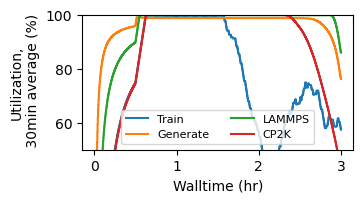

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

for task_type, events in util_data.items():
    util = [window_utilization(events, t, 30 * 60) * 100 for t in times]
    ax.step(times / 3600, util, label=task_type)

ax.set_ylim(50, 100)

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('Utilization,\n 30min average (%)')
ax.legend(ncol=2, fontsize=8)

30 minute average uptime seems a good metric to me

## Plot as a Function of Scale
Do we keep workers equally busy as a function of scale?

In [11]:
summary = []
for path in Path('../prod-runs/').glob('*-nodes'):
    nodes = int(path.name.split('-')[0])
    me = {'nodes': nodes}

    # Load the utilization data
    worker_count = get_workers_by_type(path)
    for task_type, events in count_active_workers(path, worker_count).items():
        times = np.linspace(0, events['time'].max(), 2048)[1:]
        util = [window_utilization(events, t, window_size=30*60) for t in times]
        me[f'{task_type}-util'] = max(util)
    
    summary.append(me)
summary = pd.DataFrame(summary).sort_values('nodes')
summary

,nodes,Train-util,Generate-util,LAMMPS-util,CP2K-util
1,64,0.999145,0.999948,0.999889,0.999981
2,256,0.998822,0.999888,0.999841,0.999971
0,450,0.998182,0.991529,0.999759,0.999979


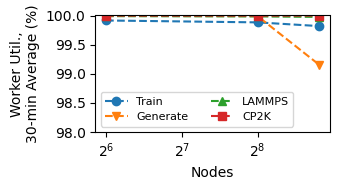

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

markers = iter(['o', 'v', '^', 's'])
for c in summary.columns:
    if not c.endswith('-util'):
        continue
    task = c.split('-')[0]

    ax.semilogx(summary['nodes'], summary[c] * 100, '--', label=task, marker=next(markers))
    ax.set_xlim(ax.get_xlim())

ax.set_xscale('log', base=2)
ax.set_xlabel('Nodes')
ax.set_ylabel('Worker Util.,\n30-min Average (%)')
ax.set_ylim(98, 100)
ax.legend(ncol=2, fontsize=8)

fig.tight_layout()
fig.savefig('figures/utilization-by-scale.png', dpi=320)
fig.savefig('figures/utilization-by-scale.pdf', dpi=320)